In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').show();
 } else {
 $('div.input').hide();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for
this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import math
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive, interact_manual
import ipywidgets as widgets
import scipy.stats as ss

%matplotlib notebook

import plotly
import susipop as sp
import pylab

import warnings
warnings.filterwarnings('ignore')

In [10]:
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f
def sort_data(x,y):
    lists = sorted(itertools.izip(*[x, y]))
    new_x, new_y = list(itertools.izip(*lists))
    return new_x, new_y

# Plot Normal Stress Differences as a function of phi

In [11]:
#phivals = [float(i)/100.0 for i in sys.argv[1:]]

phivals = [40.,45.,50.,54.,55.,56.,58.]
#solid part
ialist = ['tot','hd','lub','rep','fric']

folders = get_folder_list()
db = dict()
for p in phivals:
    db[p] = dict()
    db[p]['shearrate'] = []
    db[p]['shearstress'] = []
    for ia in ialist:
        db[p][ia] = [[],[],[]]

def num_points(max_strain):
    if max_strain < 1.0: return -5
    elif (max_strain >= 1.0) and (max_strain <=2.0): return -10

f = FloatProgress(min=0, max=100)
display(f)
L = widgets.Label("")
display(L)
progress = widgets.Label("")
display(progress)


for num,folder in enumerate(np.sort(folders[:])):
    try:
        path = folder+"/result/part_stress_norm_tot_t.dat"
        if os.path.exists(path):
            exp = reader.DataSet(folder, fluid=False, particles=True)
            exp.load_state(exp.tlist[-1])
            
            max_strain = float(exp.t)*exp.shearrate*exp.dt
            n = len(exp.tlist[1:])
            if max_strain >= 2:
                n_last_strain = int(float(n)/max_strain*(max_strain - 1))
            else:
                n_last_strain = -10
                
            f.value = float(num+1)/len(folders[:])*100
            L.value = folder
            p = round(exp.phi*100)
            db_visc = pd.read_csv(folder+"/result/nu_t.dat")
            visc = db_visc[db_visc.columns[2]]
            time = db_visc[db_visc.columns[0]]
            shearstress = np.multiply(visc,exp.shearrate)
            
            type = 'mean'  #type is 'mean' or 'all' or 'half' or 'laststrain'
            
            if type == 'mean':
                shearstress = np.mean(shearstress[n_last_strain:])
                db[p]['shearstress'].append(shearstress)
                db[p]['shearrate'].append(exp.shearrate)
            if type == 'last':
                shearstress = shearstress[-20:]
                db[p]['shearstress'].extend(list(shearstress))
                db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))
            if type == 'half':
                shearstress = shearstress[int(len(shearstress)/2):]
                db[p]['shearstress'].extend(list(shearstress))
                db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))
            if type == 'laststrain':
                shearstress = shearstress[n_last_strain:]
                db[p]['shearstress'].extend(list(shearstress))
                db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))
                
            for ia in ialist:
                path = folder+"/result/part_stress_norm_"+ia+"_t.dat"
                df = pd.read_csv(path)
                s11 = np.asarray(df[df.columns[2]])
                s22 = np.asarray(df[df.columns[3]])
                s33 = np.asarray(df[df.columns[4]])
                if type == 'last':
                    s11 = s11[-20:]
                    s22 = s22[-20:]
                    s33 = s33[-20:]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)
                if type == 'laststrain':
                    s11 = s11[n_last_strain:]
                    s22 = s22[n_last_strain:]
                    s33 = s33[n_last_strain:]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)                
                if type == 'half':
                    s11 = s11[int(len(s11)/2):]
                    s22 = s22[int(len(s22)/2):]
                    s33 = s33[int(len(s33)/2):]
                    db[p][ia][0].extend(s11)
                    db[p][ia][1].extend(s22)
                    db[p][ia][2].extend(s33)                    
                if type == 'mean':
                    s11 = np.mean(s11[n_last_strain:])
                    s22 = np.mean(s22[n_last_strain:])
                    s33 = np.mean(s33[n_last_strain:])
                    db[p][ia][0].append(s11)
                    db[p][ia][1].append(s22)
                    db[p][ia][2].append(s33)

    except Exception as e: 
        print folder,str(e)
        continue

for p in db.keys():
    for q in db[p].keys():
        db[p][q] = np.asarray(db[p][q])

rhor1_phi45_yd70.0 File rhor1_phi45_yd70.0/result/nu_t.dat does not exist
rhor1_phi56_yd30.0 No columns to parse from file


<IPython.core.display.Javascript object>


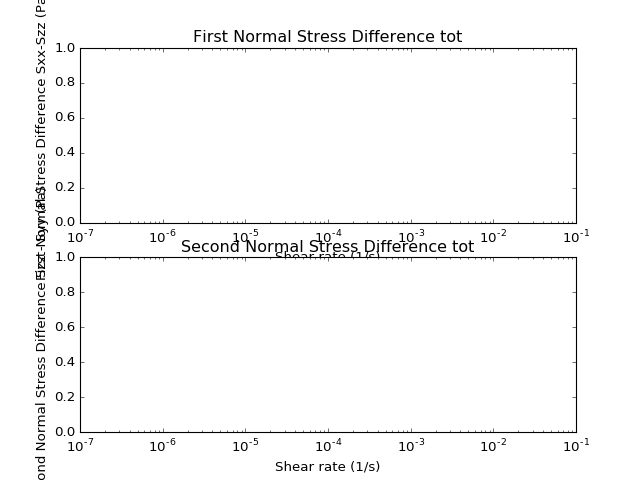

In [12]:
philist = [ 54.,55., 56.]
# for ia in ialist:
for ia in ['tot']:
#     plt.figure(figsize=[10,15])
    plt.subplot(211)
    plt.title("First Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')
        
#         plt.yscale('symlog')
        try:
#             X,Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
            X,Y = sort_data(db[p]['shearrate'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
#             X,Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
#             plt.plot(X,Y,'--o',label="phi="+str(p))
            plt.legend(loc="top left")
#             plt.xlabel('Shear Stress (Pa)')
            plt.xlabel('Shear rate (1/s)')
            plt.ylabel('First Normal Stress Difference Sxx-Szz (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.subplot(212)
    plt.title("Second Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')
#         plt.yscale('symlog')
        try:
#             X, Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
            X, Y = sort_data(db[p]['shearrate'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
#             plt.plot(X, Y ,'--o',label="phi="+str(p))
            plt.legend(loc="upper left")
#             plt.xlabel('Shear Stress (Pa)')
            plt.xlabel('Shear rate (1/s)')
            plt.ylabel('Second Normal Stress Difference Szz - Syy (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.savefig('NormalStressDifference_vs_shearrate_'+ia+'.png')

<IPython.core.display.Javascript object>


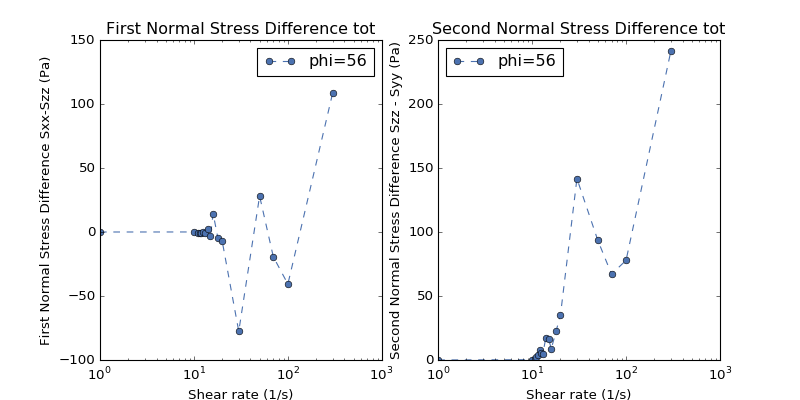

In [15]:
#phivals = [float(i)/100.0 for i in sys.argv[1:]]



def num_points(max_strain):
    if max_strain < 1.0: return -5
    elif (max_strain >= 1.0) and (max_strain <=2.0): return -10

db = dict()
def analyze_normal_stress_difference_vs_phi(type): 
    phivals = [40.,45.,50.,54.,55.,56.]
    #solid part
    ialist = ['tot','hd','lub','rep','fric']

    folders = get_folder_list()
#     db = dict()
    for p in phivals:
        db[p] = dict()
        db[p]['shearrate'] = []
        db[p]['shearstress'] = []
        for ia in ialist:
            db[p][ia] = [[],[],[]]

    f1 = FloatProgress(min=0, max=100)
    display(f1)
    L1 = widgets.Label("")
    display(L1)
    progress1 = widgets.Label("")
    display(progress1)


    for num,folder in enumerate(np.sort(folders[:])):
        try:
            path = folder+"/result/part_stress_norm_"+ia+"_t.dat"
            if os.path.exists(path):
                exp = reader.DataSet(folder, fluid=False, particles=True)
                exp.load_state(exp.tlist[-1])

                max_strain = float(exp.t)*exp.shearrate*exp.dt
                n = len(exp.tlist[1:])
                if max_strain >= 2:
                    n_last_strain = int(float(n)/max_strain*(max_strain - 1))
                    n_first_strain = int(float(n)/max_strain)
                else:
                    n_last_strain = -10
                    n_first_strain = -10

                f1.value = float(num+1)/len(folders[:])*100
                L1.value = folder
                p = round(exp.phi*100)
                db_visc = pd.read_csv(folder+"/result/nu_t.dat")
                visc = db_visc[db_visc.columns[2]]
                time = db_visc[db_visc.columns[0]]
                shearstress = np.multiply(visc,exp.shearrate)

                #type is 'mean' or 'all' or 'half' or 'laststrain'

                if type == 'mean':
                    shearstress = np.mean(shearstress[n_first_strain:])
                    db[p]['shearstress'].append(shearstress)
                    db[p]['shearrate'].append(exp.shearrate)
                if type == 'last':
                    shearstress = shearstress[-20:]
                    db[p]['shearstress'].extend(list(shearstress))
                    db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))
                if type == 'half':
                    shearstress = shearstress[int(len(shearstress)/2):]
                    db[p]['shearstress'].extend(list(shearstress))
                    db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))
                if type == 'laststrain':
                    shearstress = shearstress[n_last_strain:]
                    db[p]['shearstress'].extend(list(shearstress))
                    db[p]['shearrate'].extend(list(np.ones_like(shearstress)*exp.shearrate))

                for ia in ialist:
                    path = folder+"/result/part_stress_norm_"+ia+"_t.dat"
                    df = pd.read_csv(path)
                    s11 = np.asarray(df[df.columns[2]])
                    s22 = np.asarray(df[df.columns[3]])
                    s33 = np.asarray(df[df.columns[4]])
                    if type == 'last20':
                        s11 = s11[-20:]
                        s22 = s22[-20:]
                        s33 = s33[-20:]
                        db[p][ia][0].extend(s11)
                        db[p][ia][1].extend(s22)
                        db[p][ia][2].extend(s33)
                    if type == 'laststrain':
                        s11 = s11[n_last_strain:]
                        s22 = s22[n_last_strain:]
                        s33 = s33[n_last_strain:]
                        db[p][ia][0].extend(s11)
                        db[p][ia][1].extend(s22)
                        db[p][ia][2].extend(s33)                
                    if type == 'half':
                        s11 = s11[int(len(s11)/2):]
                        s22 = s22[int(len(s22)/2):]
                        s33 = s33[int(len(s33)/2):]
                        db[p][ia][0].extend(s11)
                        db[p][ia][1].extend(s22)
                        db[p][ia][2].extend(s33)                    
                    if type == 'mean':
                        s11 = np.mean(s11[n_first_strain:])
                        s22 = np.mean(s22[n_first_strain:])
                        s33 = np.mean(s33[n_first_strain:])
                        db[p][ia][0].append(s11)
                        db[p][ia][1].append(s22)
                        db[p][ia][2].append(s33)

        except Exception as e: 
            print folder,str(e)
            continue


    



def plot_N1N2(analyze,phivals,ia,type,x_axis):
    if analyze == "True":
        analyze_normal_stress_difference_vs_phi(type)
    for p in db.keys():
        for q in db[p].keys():
            db[p][q] = np.asarray(db[p][q])
    
    philist = phivals
    # for ia in ialist:

    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.title("First Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')

#         plt.yscale('symlog')
        try:
            if x_axis == 'shearstress':
                X,Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
                plt.plot(X,Y,'--o',label="phi="+str(p))
                plt.xlabel('Shear Stress (Pa)')
            if x_axis == 'shearrate':
                X,Y = sort_data(db[p]['shearrate'], np.asarray(db[p][ia][0])- np.asarray(db[p][ia][2]))
                plt.plot(X,Y,'--o',label="phi="+str(p))
                plt.xlabel('Shear rate (1/s)')
            plt.legend(loc="top left")
            plt.ylabel('First Normal Stress Difference Sxx-Szz (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.subplot(122)
    plt.title("Second Normal Stress Difference "+ia)
    for p in philist:
        plt.xscale('log')
#         plt.yscale('symlog')
        try:
#             X, Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
#             X, Y = sort_data(db[p]['shearrate'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
#             plt.plot(X, Y ,'--o',label="phi="+str(p))
            if x_axis == 'shearstress':
                X,Y = sort_data(db[p]['shearstress'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
                plt.plot(X,Y,'--o',label="phi="+str(p))
                plt.xlabel('Shear Stress (Pa)')
            if x_axis == 'shearrate':
                X,Y = sort_data(db[p]['shearrate'], np.asarray(db[p][ia][2])- np.asarray(db[p][ia][1]))
                plt.plot(X,Y,'--o',label="phi="+str(p))
                plt.xlabel('Shear rate (1/s)')
            plt.legend(loc="upper left")
#             plt.xlabel('Shear Stress (Pa)')
#             plt.xlabel('Shear rate (1/s)')
            plt.ylabel('Second Normal Stress Difference Szz - Syy (Pa)')
            plt.show()
        except Exception as e: 
            print str(e)
            continue
    plt.savefig('NormalStressDifference_vs_shearrate_'+ia+'.png')


v1 = interactive(plot_N1N2, \
                 analyze = widgets.ToggleButtons(options = ["True","False"]),\
                 type = widgets.ToggleButtons(options = ['mean', 'last20','half','laststrain'], value = 'mean'),\
                phivals = widgets.SelectMultiple(options=[40,45,50,54,55,56,58],value=[56],disabled=False), \
                ia= widgets.ToggleButtons(options=['tot','lub','hd','rep','fric'], value= 'tot'),\
                x_axis = widgets.ToggleButtons(options = ['shearstress','shearrate']),\
                __manual=True)

display(v1)

# Plotting the timeseries of viscosity, N, N2, Sxx, Syy, Szz 

<IPython.core.display.Javascript object>


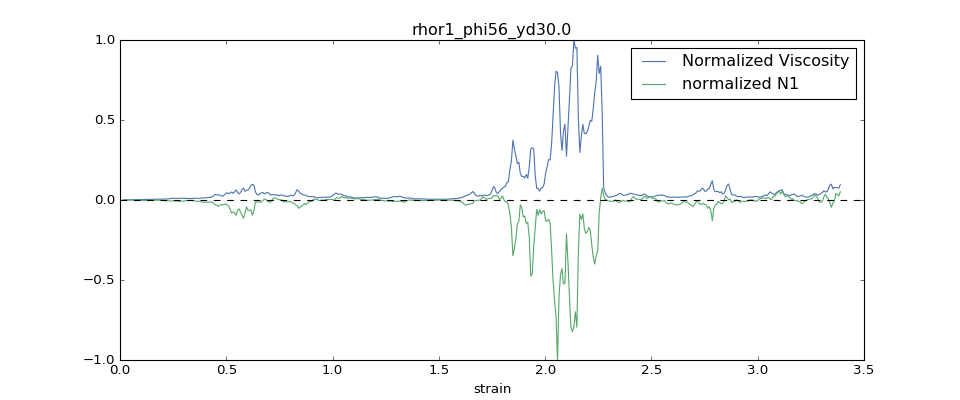

Viscosity Values are normalized by absolute value of :46.9985357302
N1 Values are normalized by absolute value of :1381.69788795
min and max N1 at timesteps : [292] [322]  or [-193] [-163] 483


In [14]:
# max_n1 = widgets.Label("N1 Values are normalized by absolute value of :")
# display(max_n1)
# max_n2 = widgets.Label("N2 Values are normalized by absolute value of :")
# display(max_n2)
def plot_timeseries(phival,ydval,ia,viscosity,n1,n2,s1,s2,s3):

    plt.style.use('seaborn-deep')
    path = "rhor1_phi"+str(phival)+"_yd"+str(float(ydval))

    nufile = path+"/result/nu_t.dat" 
    stressfile = path+"/result/part_stress_norm_"+ia+"_t.dat" 
    
    
    
    if os.path.exists(nufile):
        plt.figure(figsize=[12,5])

        minshear = 100000
        db = pd.read_csv(nufile)
        nu = db[db.columns[2]]
        nu_rel = db[db.columns[4]]
        t = db[db.columns[1]]
        shearrate = float(nufile.split("_")[2].split("/")[0].split("yd")[1])

        shear = t*shearrate
        if minshear > shear.max(): minshear = shear.max()
        nu = nu_rel*1.002e-3
#         plt.plot(shear,np.log10(nu_rel),label="log10 Viscosity")
        if viscosity:
            print "Viscosity Values are normalized by absolute value of :" + str(max(abs(nu[:len(shear)])))
            plt.plot(shear,nu/max(nu),label="Normalized Viscosity")
        
        df = pd.read_csv(stressfile)
        s11 = np.asarray(df[df.columns[2]])
        s22 = np.asarray(df[df.columns[3]])
        s33 = np.asarray(df[df.columns[4]])
        N1 = s11 - s33
        N2 = s33 - s22
        if s1: 
            print "Sxx Values are normalized by absolute value of :" + str(max(abs(s11[:len(shear)])))
            plt.plot(shear,s11[:len(shear)]/max(abs(s11[:len(shear)])),label = "Sxx")
        if s2: 
            print "Syy Values are normalized by absolute value of :" + str(max(abs(s22[:len(shear)])))
            plt.plot(shear,s22[:len(shear)][:len(shear)]/max(abs(s22[:len(shear)])),label = "Syy")
        if s3: 
            print "Szz Values are normalized by absolute value of :" + str(max(abs(s33[:len(shear)])))
            plt.plot(shear,s33[:len(shear)]/max(abs(s33[:len(shear)])),label = "Szz")
            
        if n1:
#             max_n1.value = "N1 Values are normalized by absolute value of :" + str(max(abs(N1[:len(shear)])))
            print "N1 Values are normalized by absolute value of :" + str(max(abs(N1[:len(shear)])))
            plt.plot(shear,N1[:len(shear)]/max(abs(N1[:len(shear)])),label="normalized N1")
            idx_min = np.where(N1 == N1.min())[0]
            idx_max = np.where(N1 == N1.max())[0]
            print "min and max N1 at timesteps :",idx_min, idx_max, " or", idx_min - len(N1)-2, idx_max- len(N1)-2, len(N1)
        if n2:
#             max_n2.value = "N2 Values are normalized by absolute value of :" + str(max(abs(N2[:len(shear)])))
            print "N2 Values are normalized by absolute value of :" + str(max(abs(N2[:len(shear)])))
            plt.plot(shear,N2[:len(shear)]/max(abs(N2[:len(shear)])),label="normalized N2")
        
        plt.legend(loc="best")
        plt.title(path)
#         plt.yscale("symlog")
        plt.xlabel("strain")
#         plt.ylabel(" viscosity Pa.s")
        plt.axhline(0,color = 'k',ls = '--')
    #     plt.xlim([0,minshear])
        name = "comparison_viscosity_" + str(phival)+ '_'+str(ydval)
    #     plt.savefig(name)
    else:
        print "no data found, check location"
v = interactive(plot_timeseries, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                ydval= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000], value= 10),\
                ia = widgets.ToggleButtons(options = ['tot','fric','rep','lub'],value = 'tot'),\
                viscosity=widgets.widget_bool.Checkbox(value = True, description = "Viscosity"),\
                n1=widgets.widget_bool.Checkbox(value = True, description = "N1"),\
                n2=widgets.widget_bool.Checkbox(value = False,description = "N2"),\
                 s1=widgets.widget_bool.Checkbox(value = False,description = "Sxx"),\
                 s2=widgets.widget_bool.Checkbox(value = False,description = "Syy"),\
                 s3=widgets.widget_bool.Checkbox(value = False,description = "Szz"),\
                
                __manual=False)

# display(v)
display(widgets.VBox(v.children[:3]))
display(widgets.HBox(v.children[3:9]))
